# Introduction to python and JupyterLab

We understand that some students might not have used python and JupyterLab.
But it would be too much to cover a detailed introduction to python and JupyterLab in a one-day course.
So we expect that students will learn some basic concepts before the course in their own way.
As a start to python and jupyter, please have a look at their official website:

Python:
* https://www.python.org/

jupyter (lab):
* https://jupyterlab.readthedocs.io/en/stable/
* https://jupyter.org/

# Python for map plot

In this section we will provide some examples for climate data related analysis.

## Import packages

In [1]:
import numpy as np
import xarray as xr
import cartopy as ctp
import matplotlib.pyplot as plt
import os
os.getcwd()
import matplotlib as mpl
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
import matplotlib.path as mpath

## Examples for plotting

### Global map

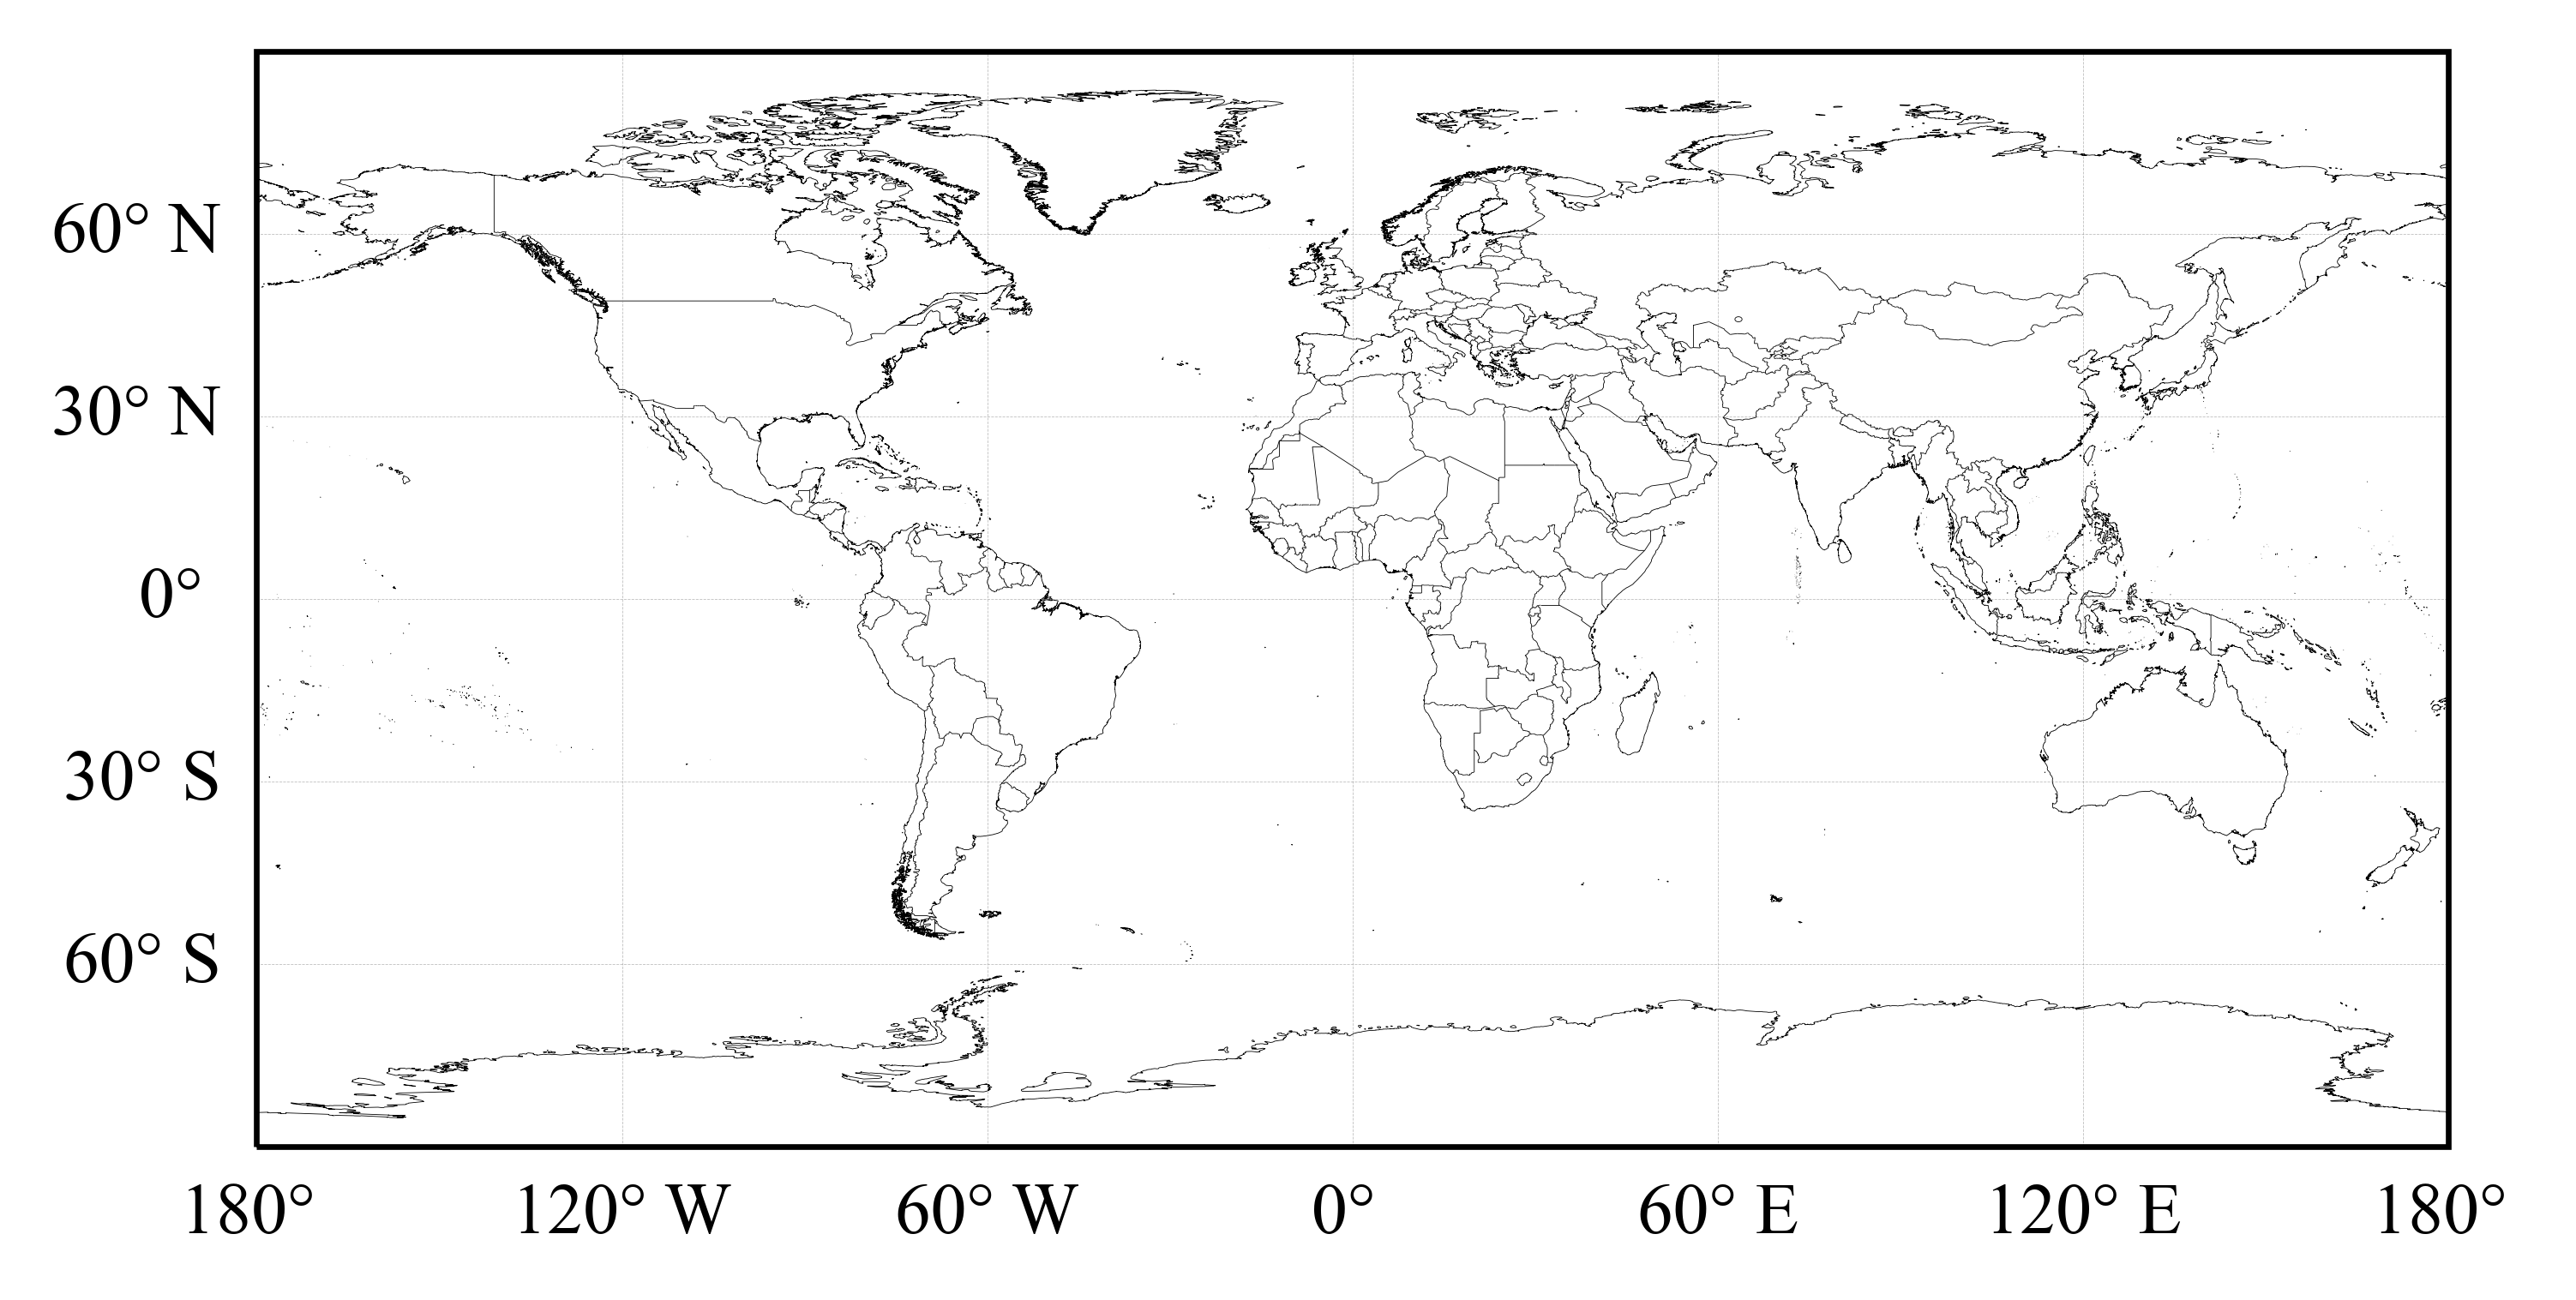

In [2]:
# Specify the resolution of figures. Most journals require a resolution larger than 300 dpi. But they might limit the figure size to 2 MB. So something between 300-600 is what you want.
mpl.rcParams['figure.dpi'] = 600

# Specify the font size. You can decide whether to use different font size for xy-ticks labels, axis labels, and figure titles.
# If you can not use the font 'Times New Roman', try install this package with conda : "conda install -c conda-forge mscorefonts".
mpl.rc('font', family='Times New Roman', size=10)

# more info (inputs and outputs) about the function plt.subplots: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
# more info about available projections: https://scitools.org.uk/cartopy/docs/latest/reference/projections.html
fig, ax = plt.subplots(
    nrows=1, ncols=1,
    figsize = np.array([13.2, 6.6]) / 2.54, # figure size in inches
    subplot_kw={'projection': ctp.crs.PlateCarree()},
    )

# Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
# See: https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html#cartopy.mpl.geoaxes.GeoAxes.set_extent
ax.set_extent(
    [-180, 180, -90, 90],
    crs = ctp.crs.PlateCarree(),
    )

# Set the x ticks
# Note np.arange(-180, 180, 60) will not get 180, so We should specify 181 here
# more infor about np.arange: https://numpy.org/doc/stable/reference/generated/numpy.arange.html
# ax.set_xticks(np.arange(-180, 181, 60))
# ax.set_xticklabels(np.arange(-180, 181, 60))
# ax.set_yticks(np.arange(-90, 91, 30))
# ax.set_yticklabels(np.arange(-90, 91, 30))

# Add costline: https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.feature.NaturalEarthFeature.html
coastline = ctp.feature.NaturalEarthFeature(
    'physical', 'coastline', '10m', edgecolor='black',
    facecolor='none', lw = 0.1)
ax.add_feature(coastline)
# Add country borders
borders = ctp.feature.NaturalEarthFeature(
    'cultural', 'admin_0_boundary_lines_land', '10m', edgecolor='black',
    facecolor='none', lw = 0.1)
ax.add_feature(borders)

gl = ax.gridlines(
    crs = ctp.crs.PlateCarree(), linewidth = 0.1,
    color = 'gray', alpha = 0.5, linestyle='--',
    xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
    draw_labels=["bottom", "left"],
    # some journals (e.g. copernicus requires there is a space between '°' and direction sign like 'N')
    xformatter=LongitudeFormatter(degree_symbol='° '),
    yformatter=LatitudeFormatter(degree_symbol='° '),)

# Adjust the edge of plot
fig.subplots_adjust(left=0.12, right = 0.94, bottom = 0.1, top = 0.99)

# show the image
plt.show()
# or save it
# fig.savefig('trial.png', dpi=600)


### Southern Hemisphere map

[None, None, None, None, None]

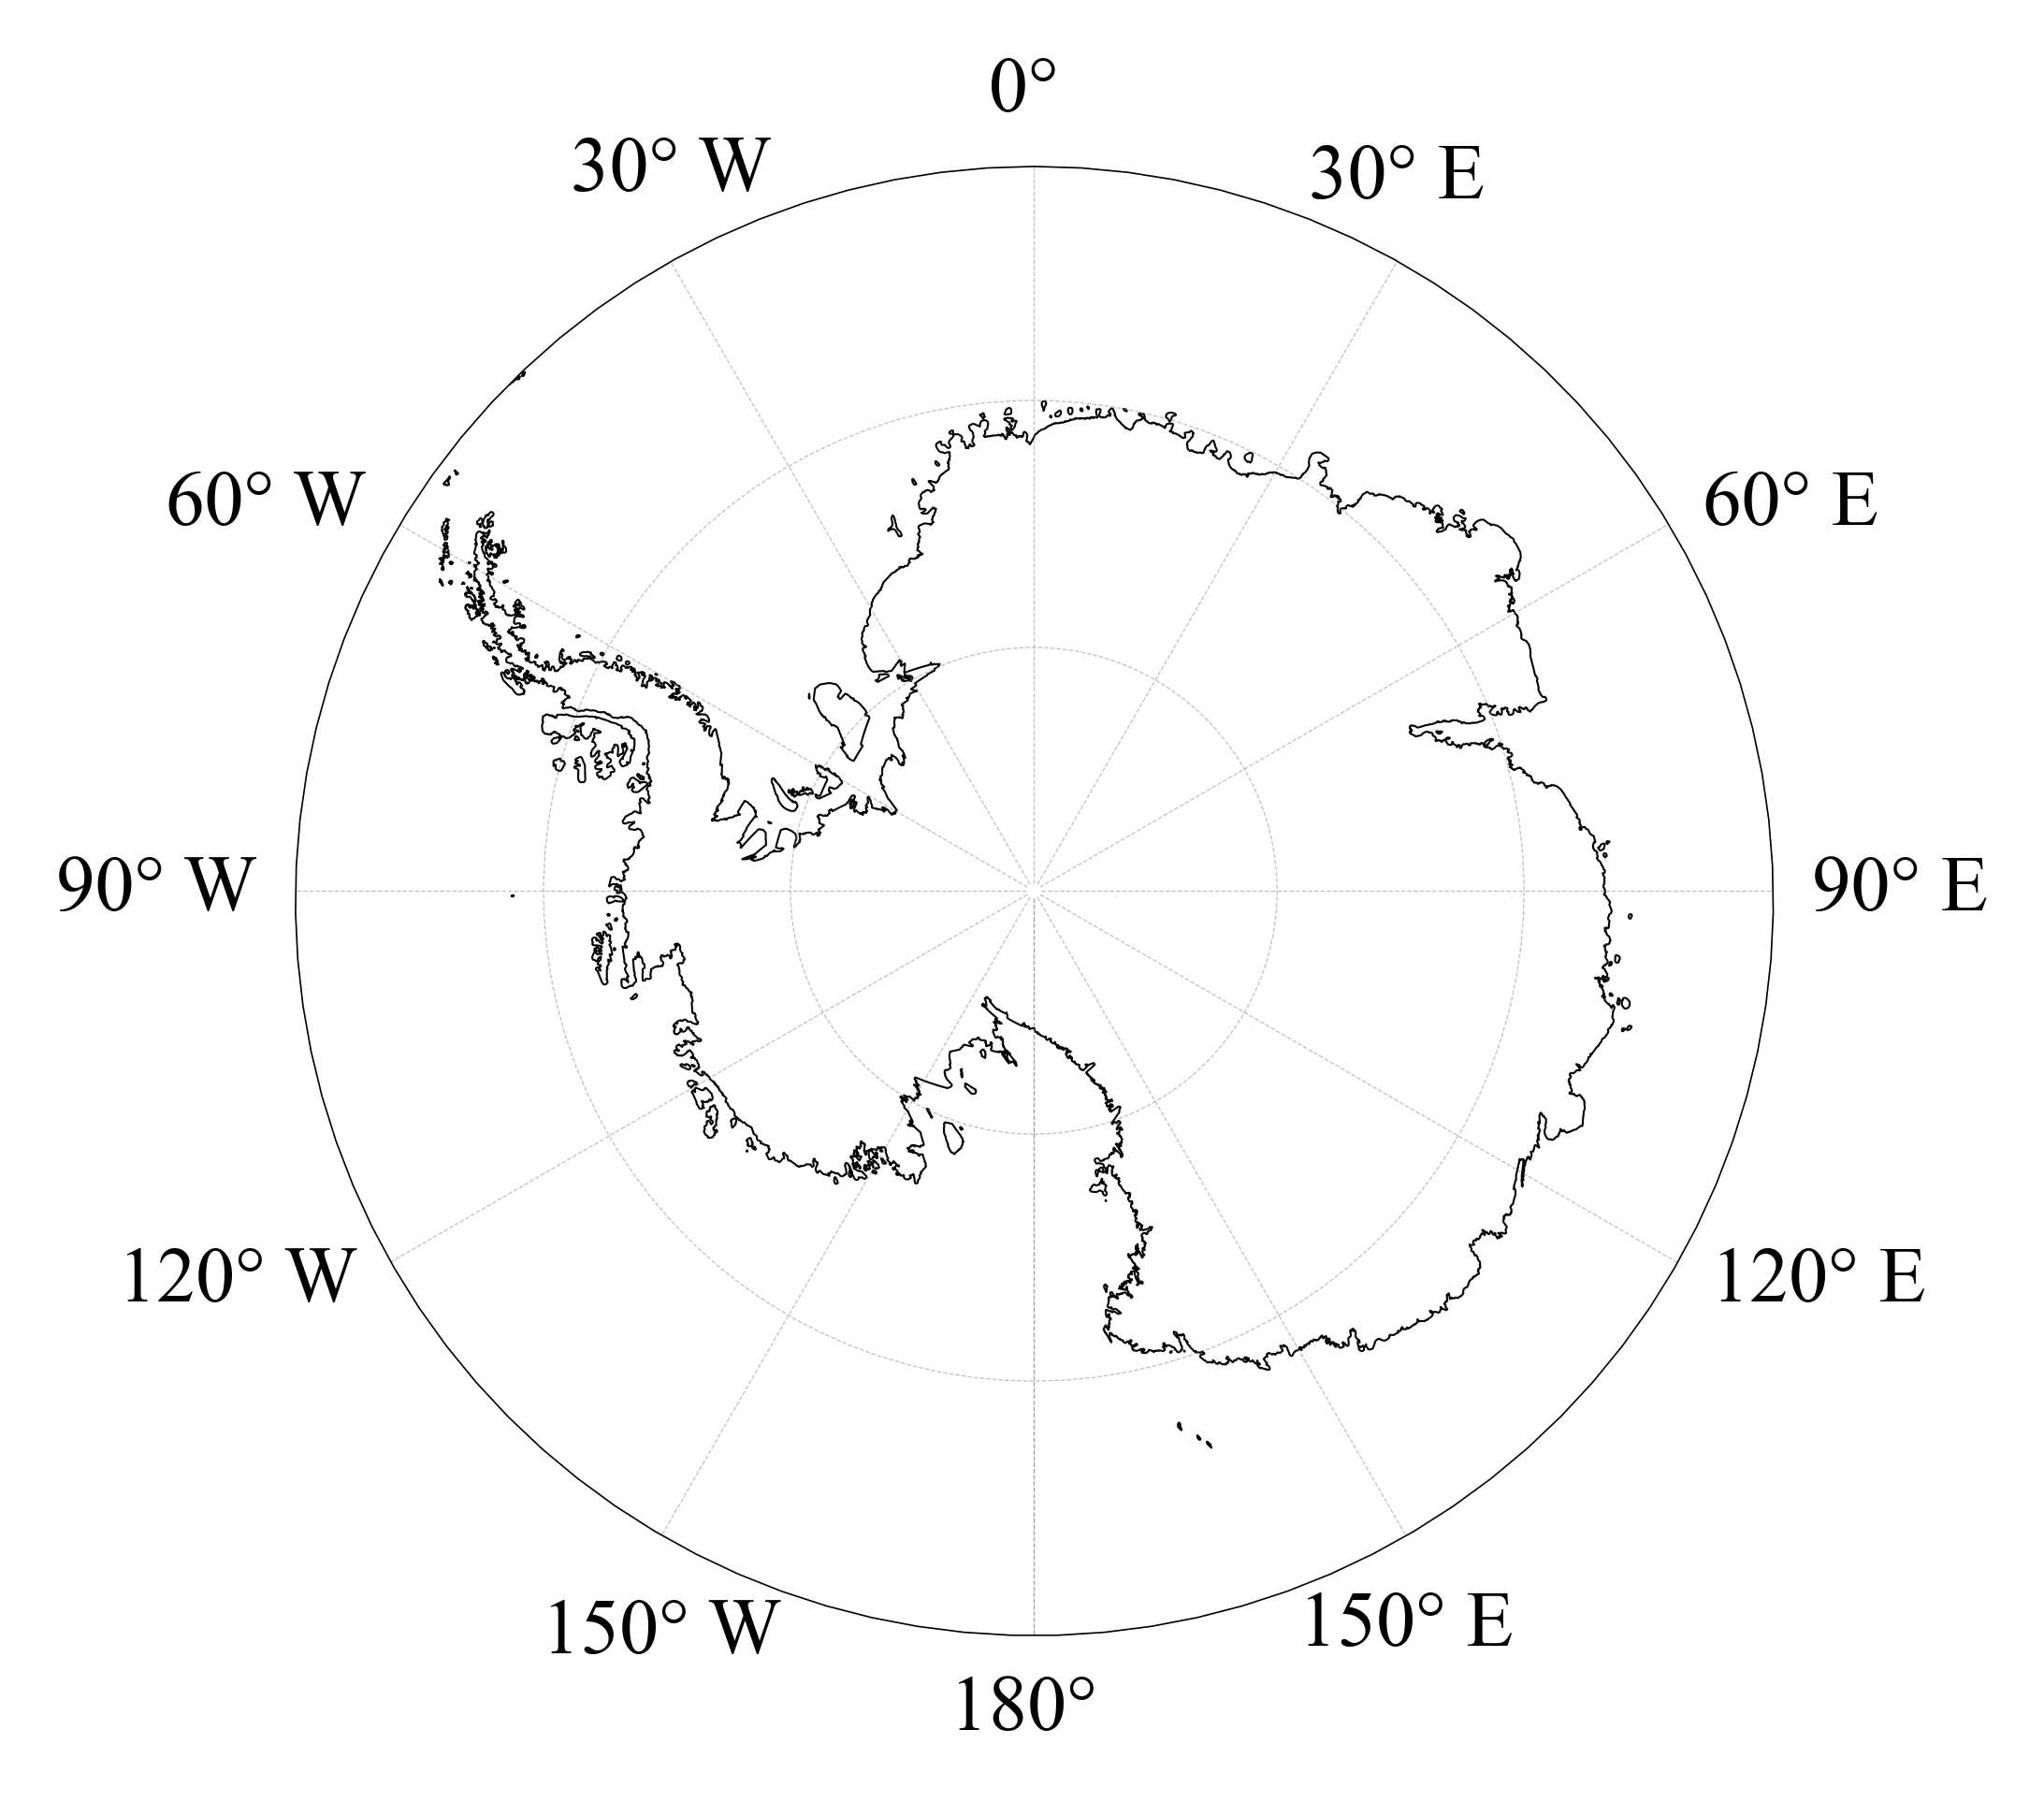

In [3]:
# The projection used for SH is ctp.crs.SouthPolarStereo().
fig, ax = plt.subplots(
    1, 1, figsize=np.array([8.8, 9.3]) / 2.54,
    subplot_kw={'projection': ctp.crs.SouthPolarStereo()},)

# When we set the extent, we specify crs as ctp.crs.PlateCarree() because the data here is in regular longitude, latitude.
ax.set_extent((-180, 180, -90, -60), crs = ctp.crs.PlateCarree())

coastline = ctp.feature.NaturalEarthFeature(
    'physical', 'coastline', '10m', edgecolor='black',
    facecolor='none', lw=0.25)
ax.add_feature(coastline, zorder=2)
gl = ax.gridlines(
    crs=ctp.crs.PlateCarree(), linewidth=0.15, zorder=2, draw_labels=True,
    color='gray', alpha=0.5, linestyle='--',
    xlocs=np.arange(-180, 181, 30), ylocs=np.arange(-90, -59, 10),
    xformatter=LongitudeFormatter(degree_symbol='° '),
    yformatter=LatitudeFormatter(degree_symbol='° '),
    rotate_labels = False,
    )
# You might not wanna see the ylabels
gl.ylabel_style = {'size': 0, 'color': None, 'alpha': 0}

fig.subplots_adjust(left=0.12, right=0.88, bottom=0.08, top=0.96)

# set circular axes boundaries. You do not need to understand the mechanisms, so do I.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

plt.setp(ax.spines.values(), linewidth=0.2)


### Write modules to plot maps

It is good to be able to plot nice maps in python like that.
But for real analysis, it can be just heavy to write such long codes to plot a map every time.
So in python, we normally write a function to do such a job, which allows you to do a job with just a call to the function, and do a similar job with just changing a few parameters.
Below is a example:

#### A function to plot SH and NH

In [4]:
def hemisphere_plot(
    northextent=None, southextent=None, figsize=None,
    fm_left=0.12, fm_right=0.88, fm_bottom=0.08, fm_top=0.96,
    ax_org = None,
    ):
    '''
    ----Input
    northextent: plot SH, north extent in degree south, e.g. -60, -30, or 0;
    southextent: plot NH, south extent in degree north, e.g. 60, 30, 0;
    figsize: figure size, e.g. np.array([8.8, 9.3]) / 2.54;
    fm_*: the space around four side of the graph
    ax_org: if specified, it will not create a new fig and ax.
    
    ----output
    (fig, ax): fig and ax object as returned by standard plotting function of matplotlib.
    
    ----function dependence
    None
    '''
    
    import numpy as np
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib as mpl
    import matplotlib.path as mpath
    from cartopy.mpl.ticker import LongitudeFormatter
    from cartopy.mpl.ticker import LatitudeFormatter
    mpl.rc('font', family='Times New Roman', size=10)
    mpl.rcParams['figure.dpi'] = 600
    import warnings
    warnings.filterwarnings('ignore')
    
    if (figsize is None):
        figsize = np.array([8.8, 9.3]) / 2.54
    
    if not (northextent is None):
        # If you specified northextent, this function will plot SH. And it will ignore 'southextent'.
        projections = ccrs.SouthPolarStereo()
        extent = (-180, 180, -90, northextent)
        yticks = np.arange(-90, northextent + 1, 10)
    elif not (southextent is None):
        projections = ccrs.NorthPolarStereo()
        extent = (-180, 180, southextent, 90)
        yticks = np.arange(southextent - 1, 90, 10)
    
    transform = ccrs.PlateCarree()
    
    if (ax_org is None):
        fig, ax = plt.subplots(
            1, 1, figsize=figsize, subplot_kw={'projection': projections},
            )
    else:
        ax = ax_org
    
    ax.set_extent(extent, crs=transform)
    
    coastline = cfeature.NaturalEarthFeature(
        'physical', 'coastline', '10m', edgecolor='black',
        facecolor='none', lw=0.25)
    ax.add_feature(coastline, zorder=2)
    borders = cfeature.NaturalEarthFeature(
        'cultural', 'admin_0_boundary_lines_land', '10m',
        edgecolor='black', facecolor='none', lw=0.25)
    ax.add_feature(borders, zorder=2)
    
    gl = ax.gridlines(
        crs=transform, linewidth=0.15, zorder=2,
        draw_labels=True, color='gray', alpha=0.5, linestyle='--',
        xlocs=np.arange(-180, 181, 30), ylocs=yticks, rotate_labels=False,
        xformatter=LongitudeFormatter(degree_symbol='° '),
        yformatter=LatitudeFormatter(degree_symbol='° '),
    )
    gl.ylabel_style = {'size': 0, 'color': None, 'alpha': 0}
    
    # set circular axes boundaries
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    plt.setp(ax.spines.values(), linewidth=0.2)
    
    if (ax_org is None):
        fig.subplots_adjust(
            left=fm_left, right=fm_right, bottom=fm_bottom, top=fm_top)
        return fig, ax
    else:
        return ax


#### Use the function to plot SH and NH

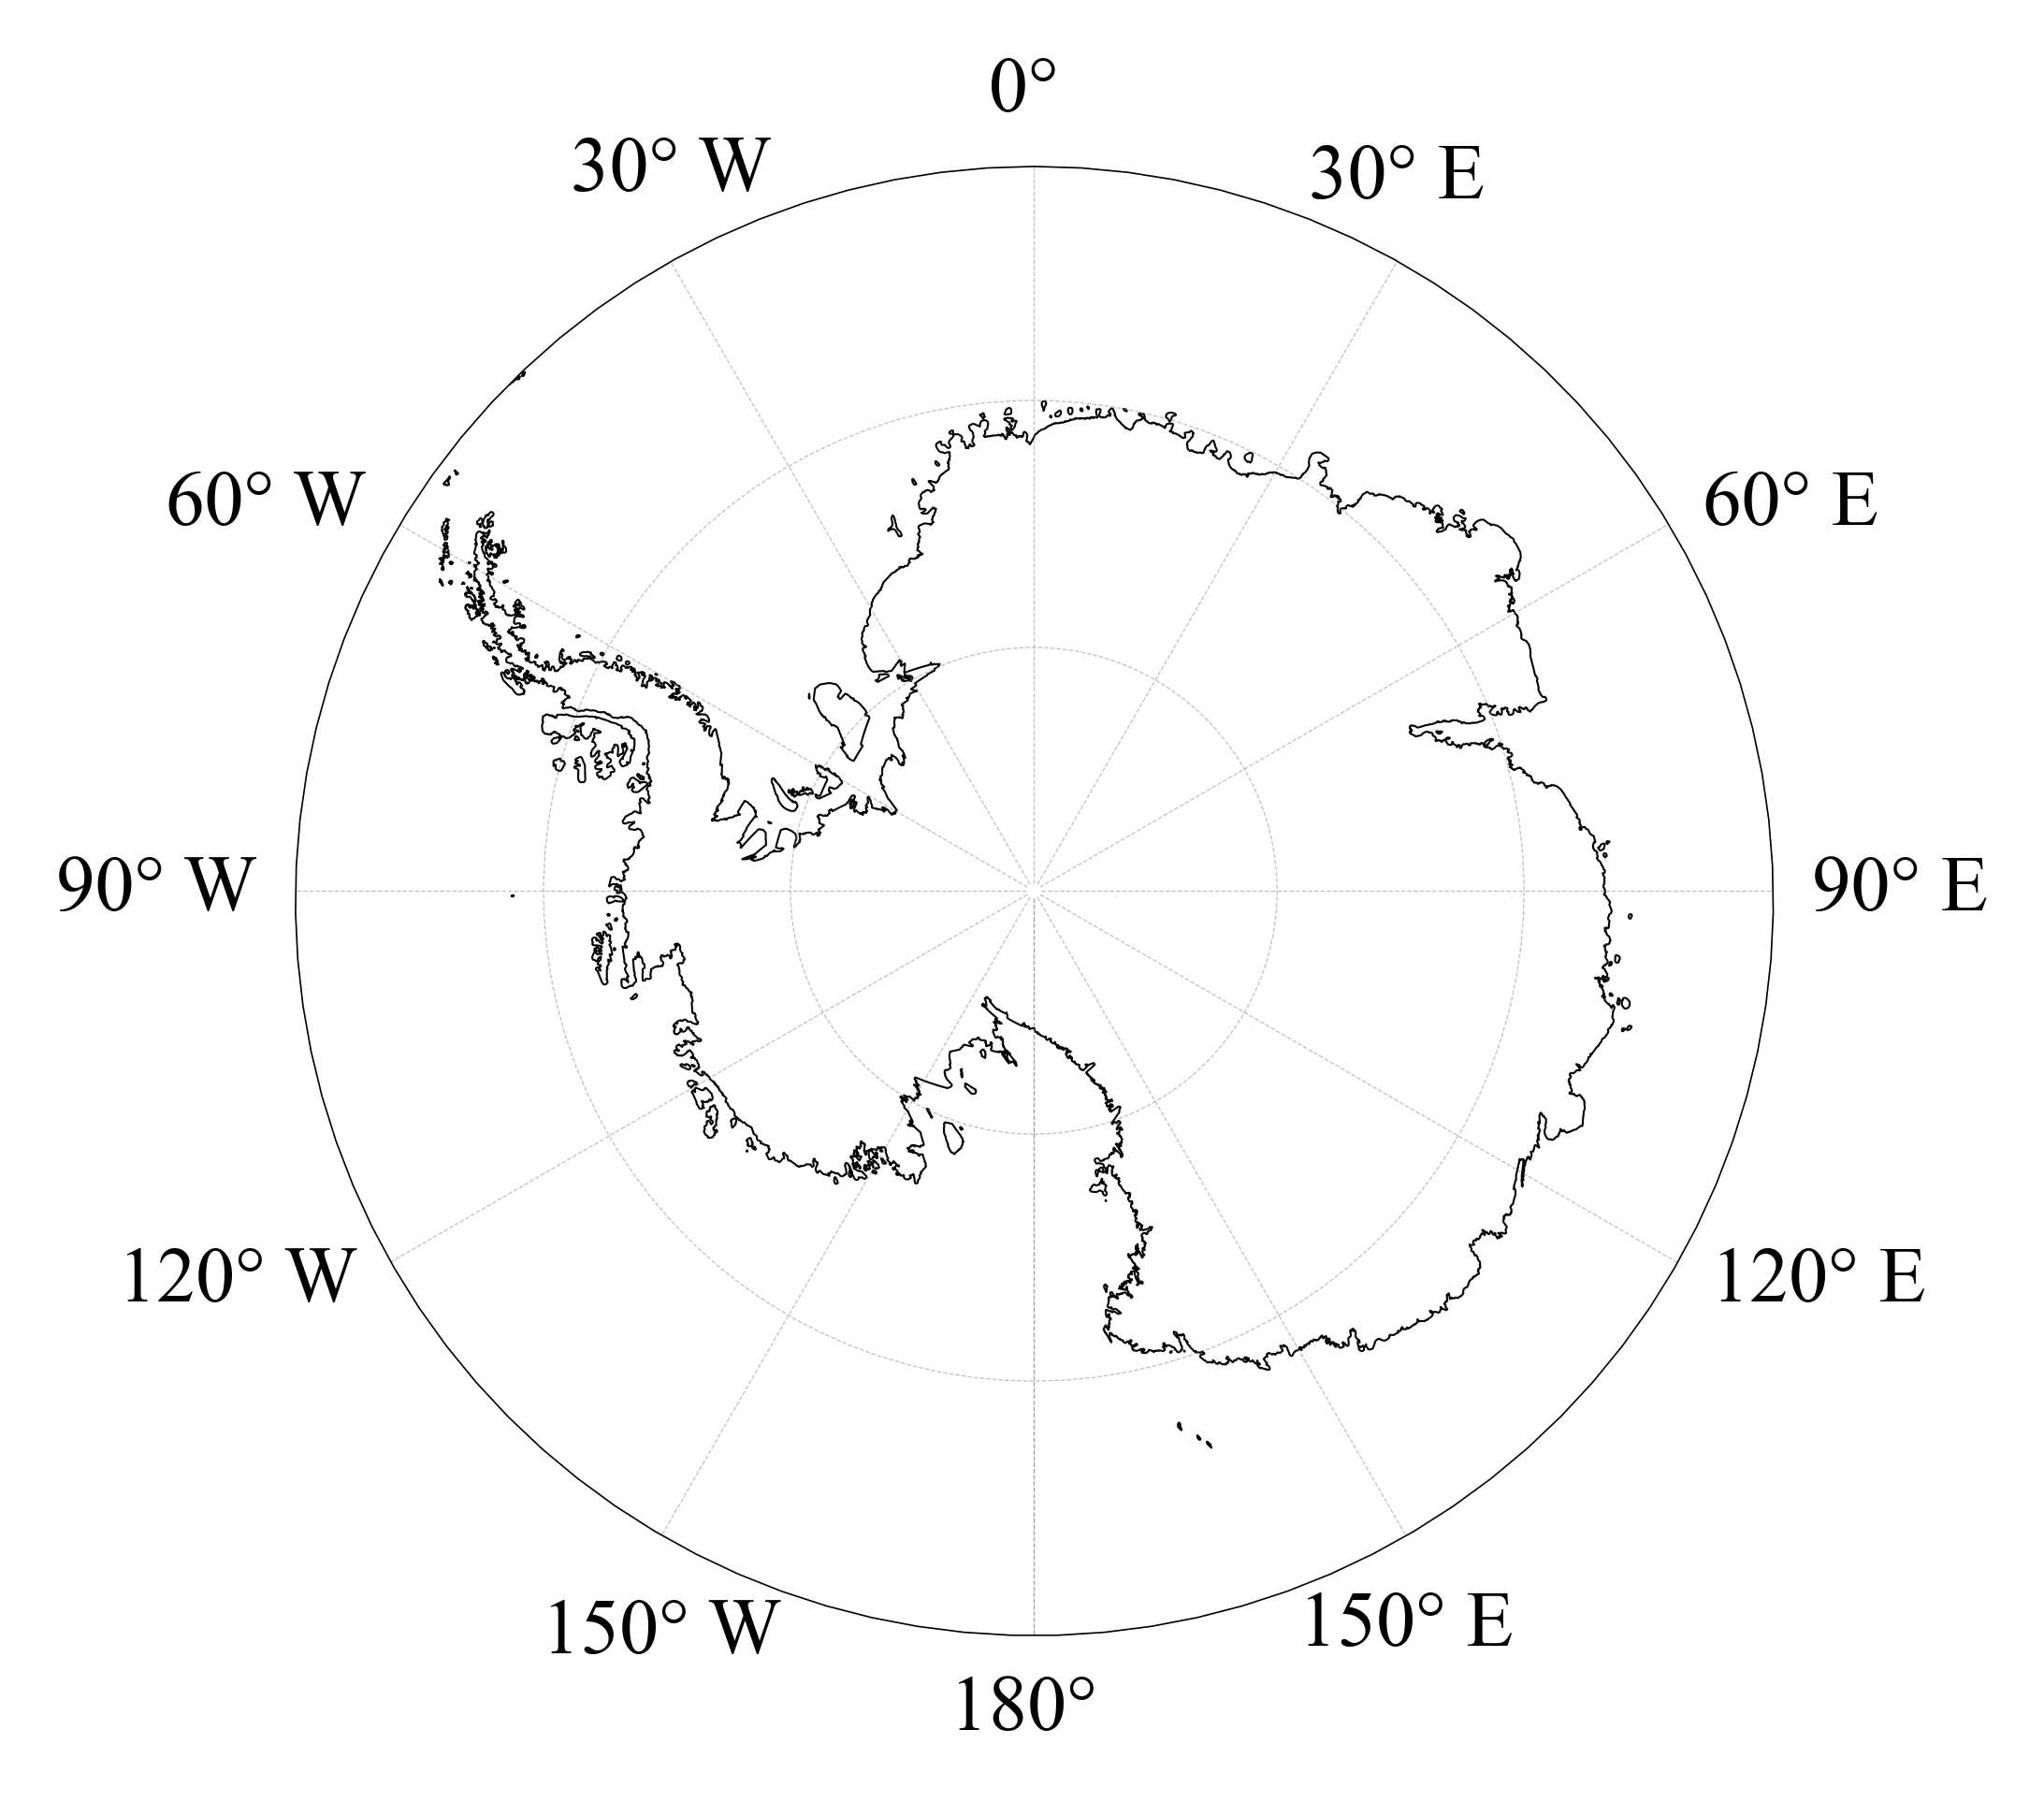

In [5]:
fig, ax = hemisphere_plot(northextent=-60,)

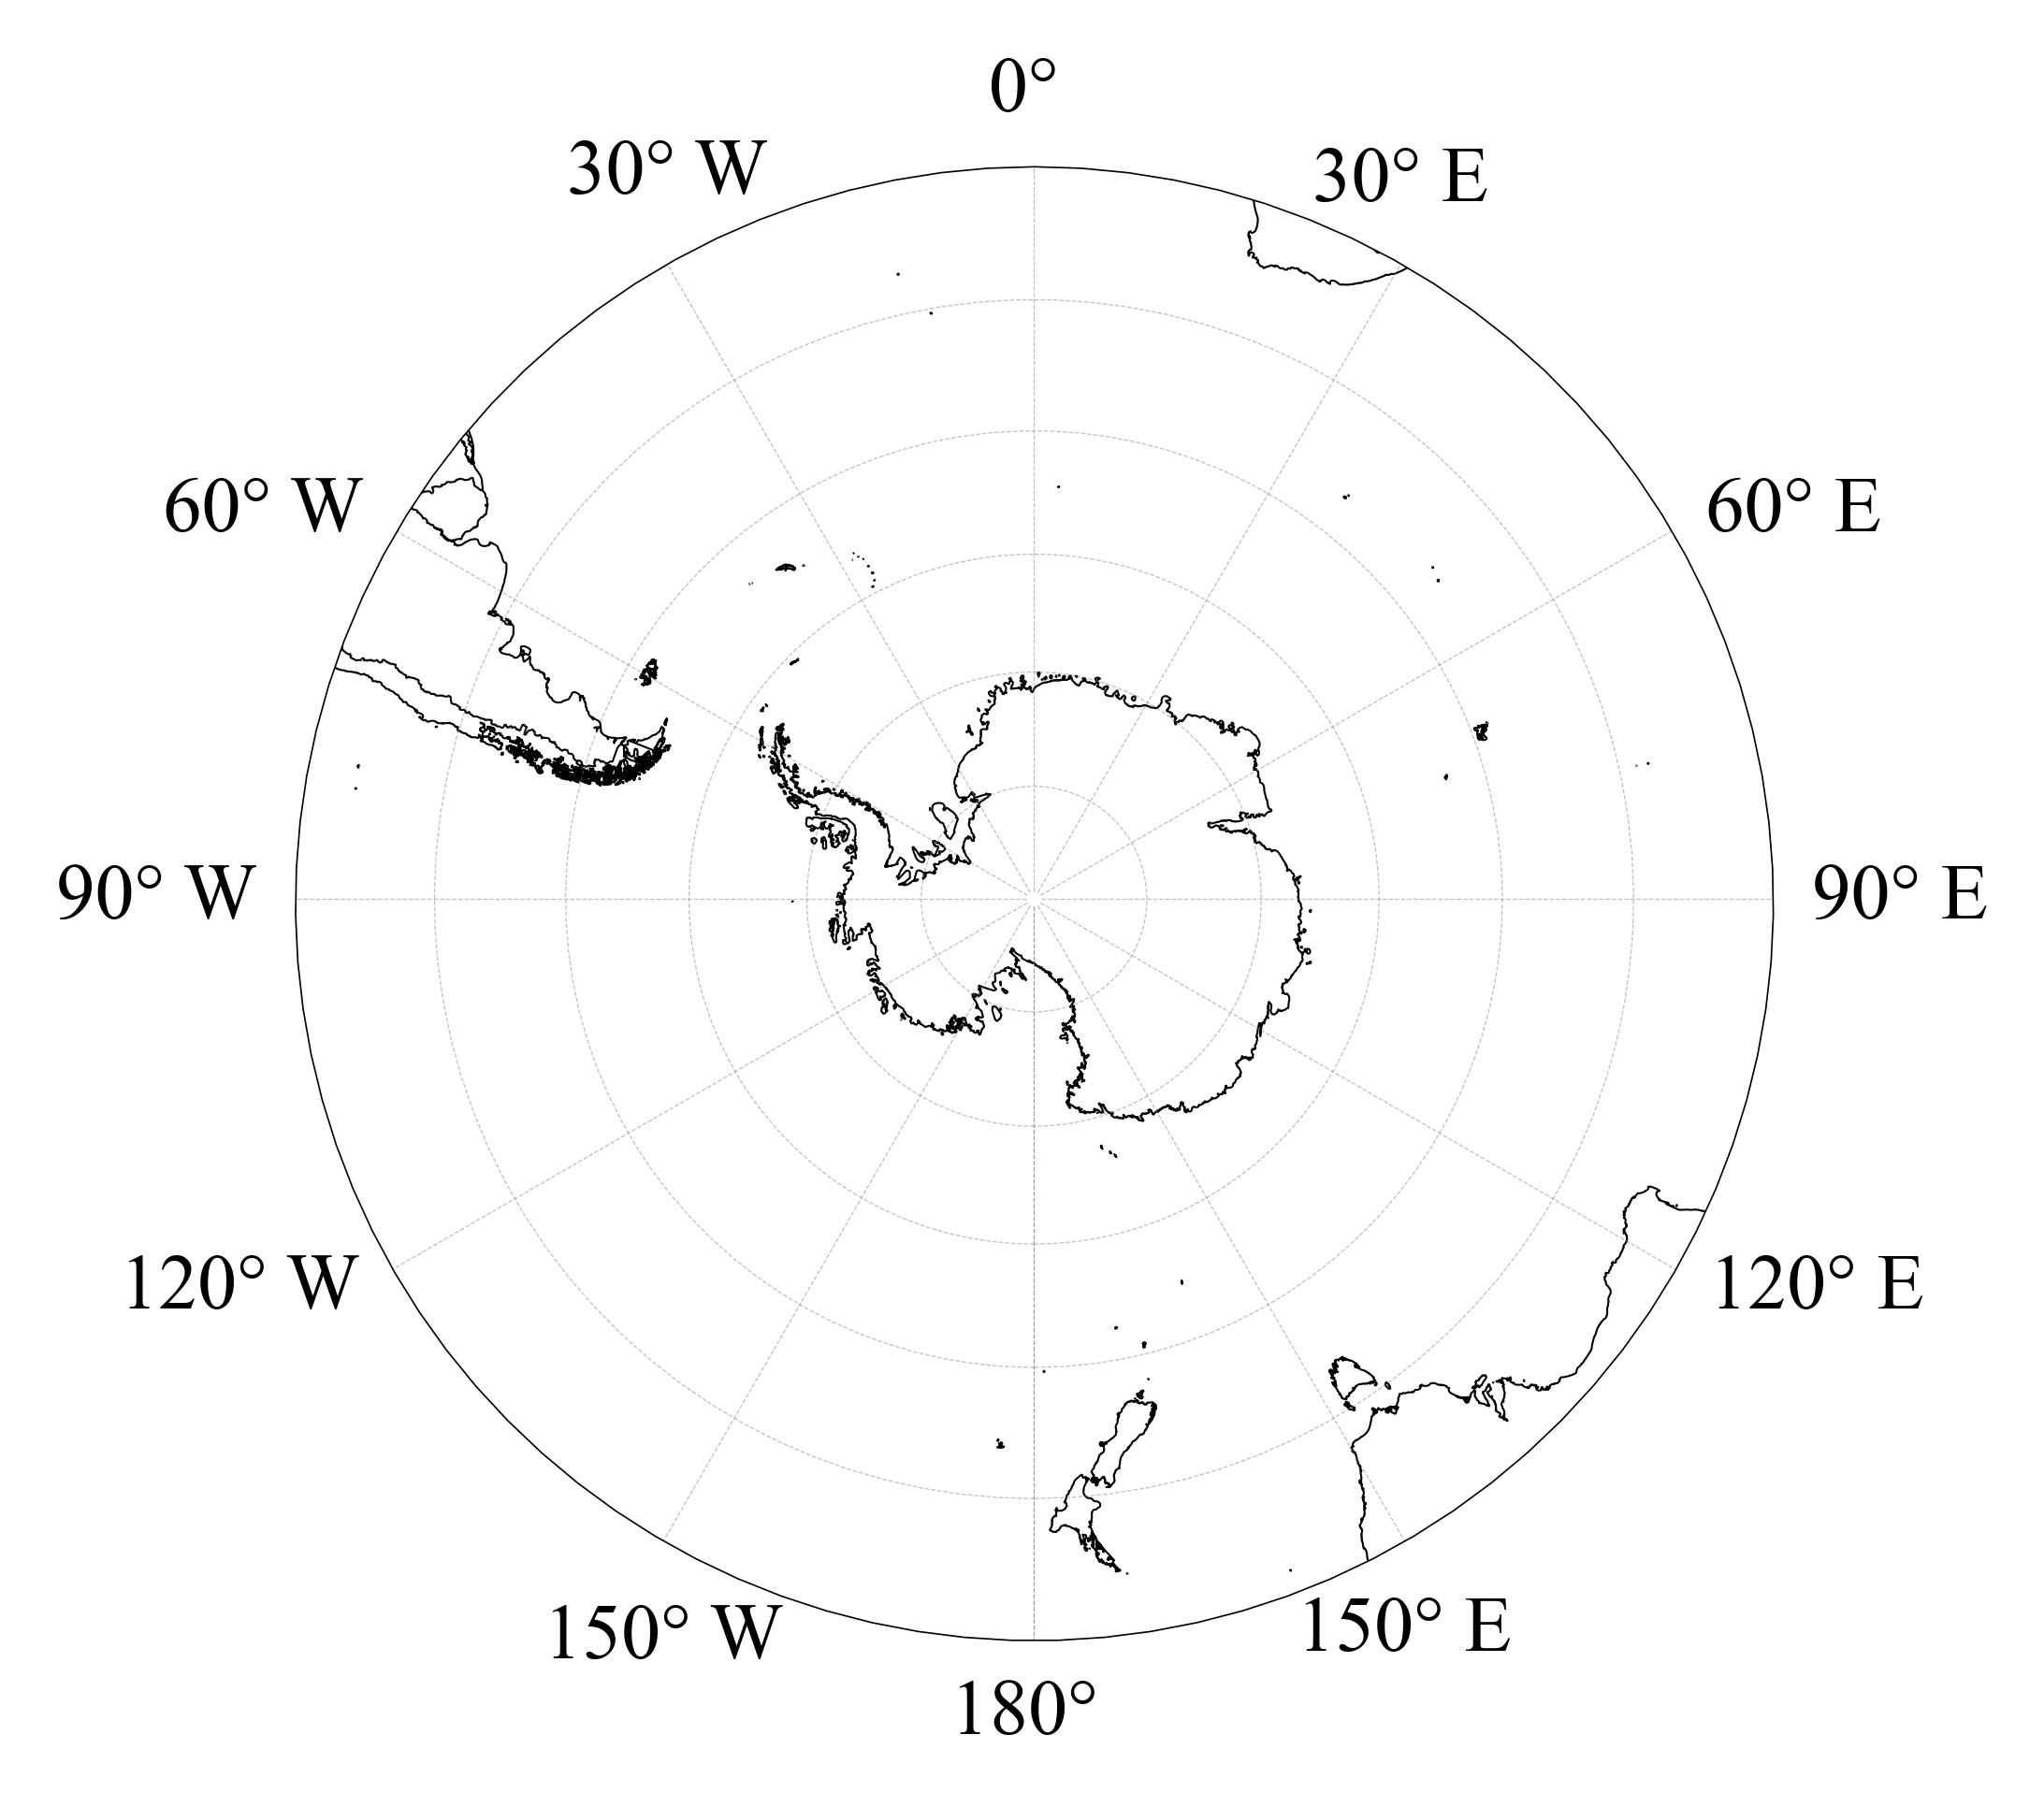

In [6]:
fig, ax = hemisphere_plot(northextent=-30,)

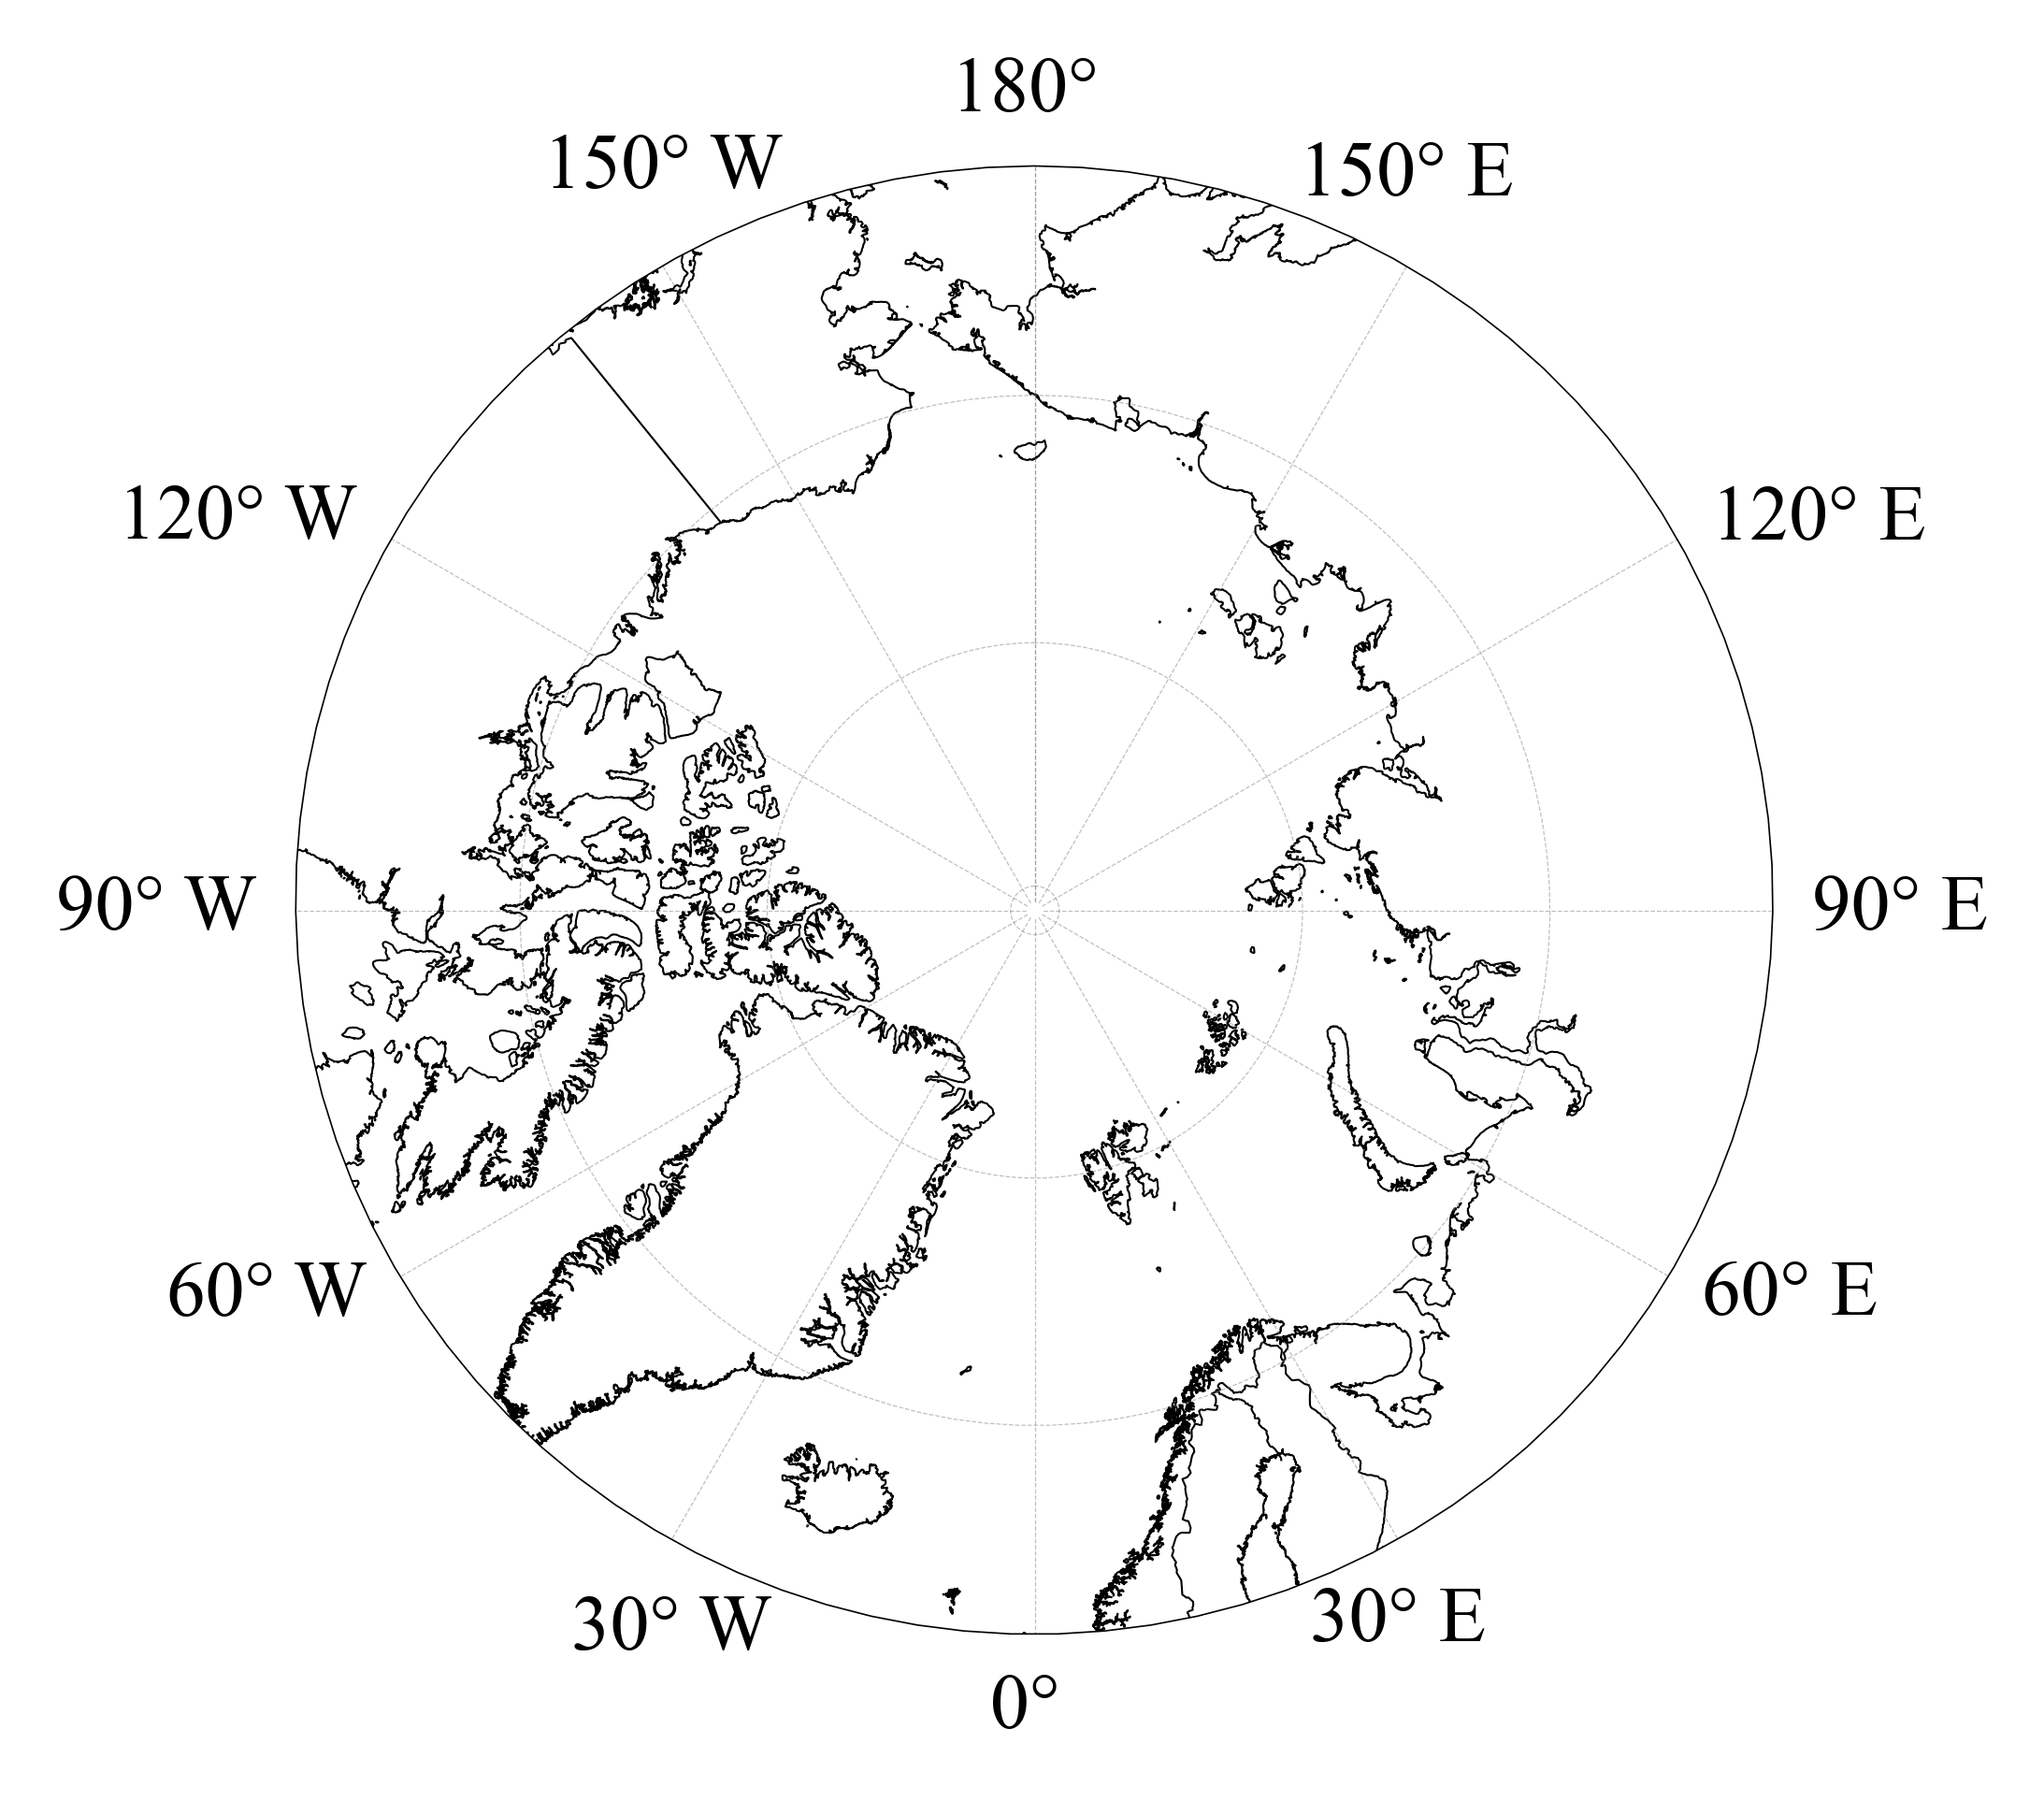

In [7]:
fig, ax = hemisphere_plot(southextent=60,)

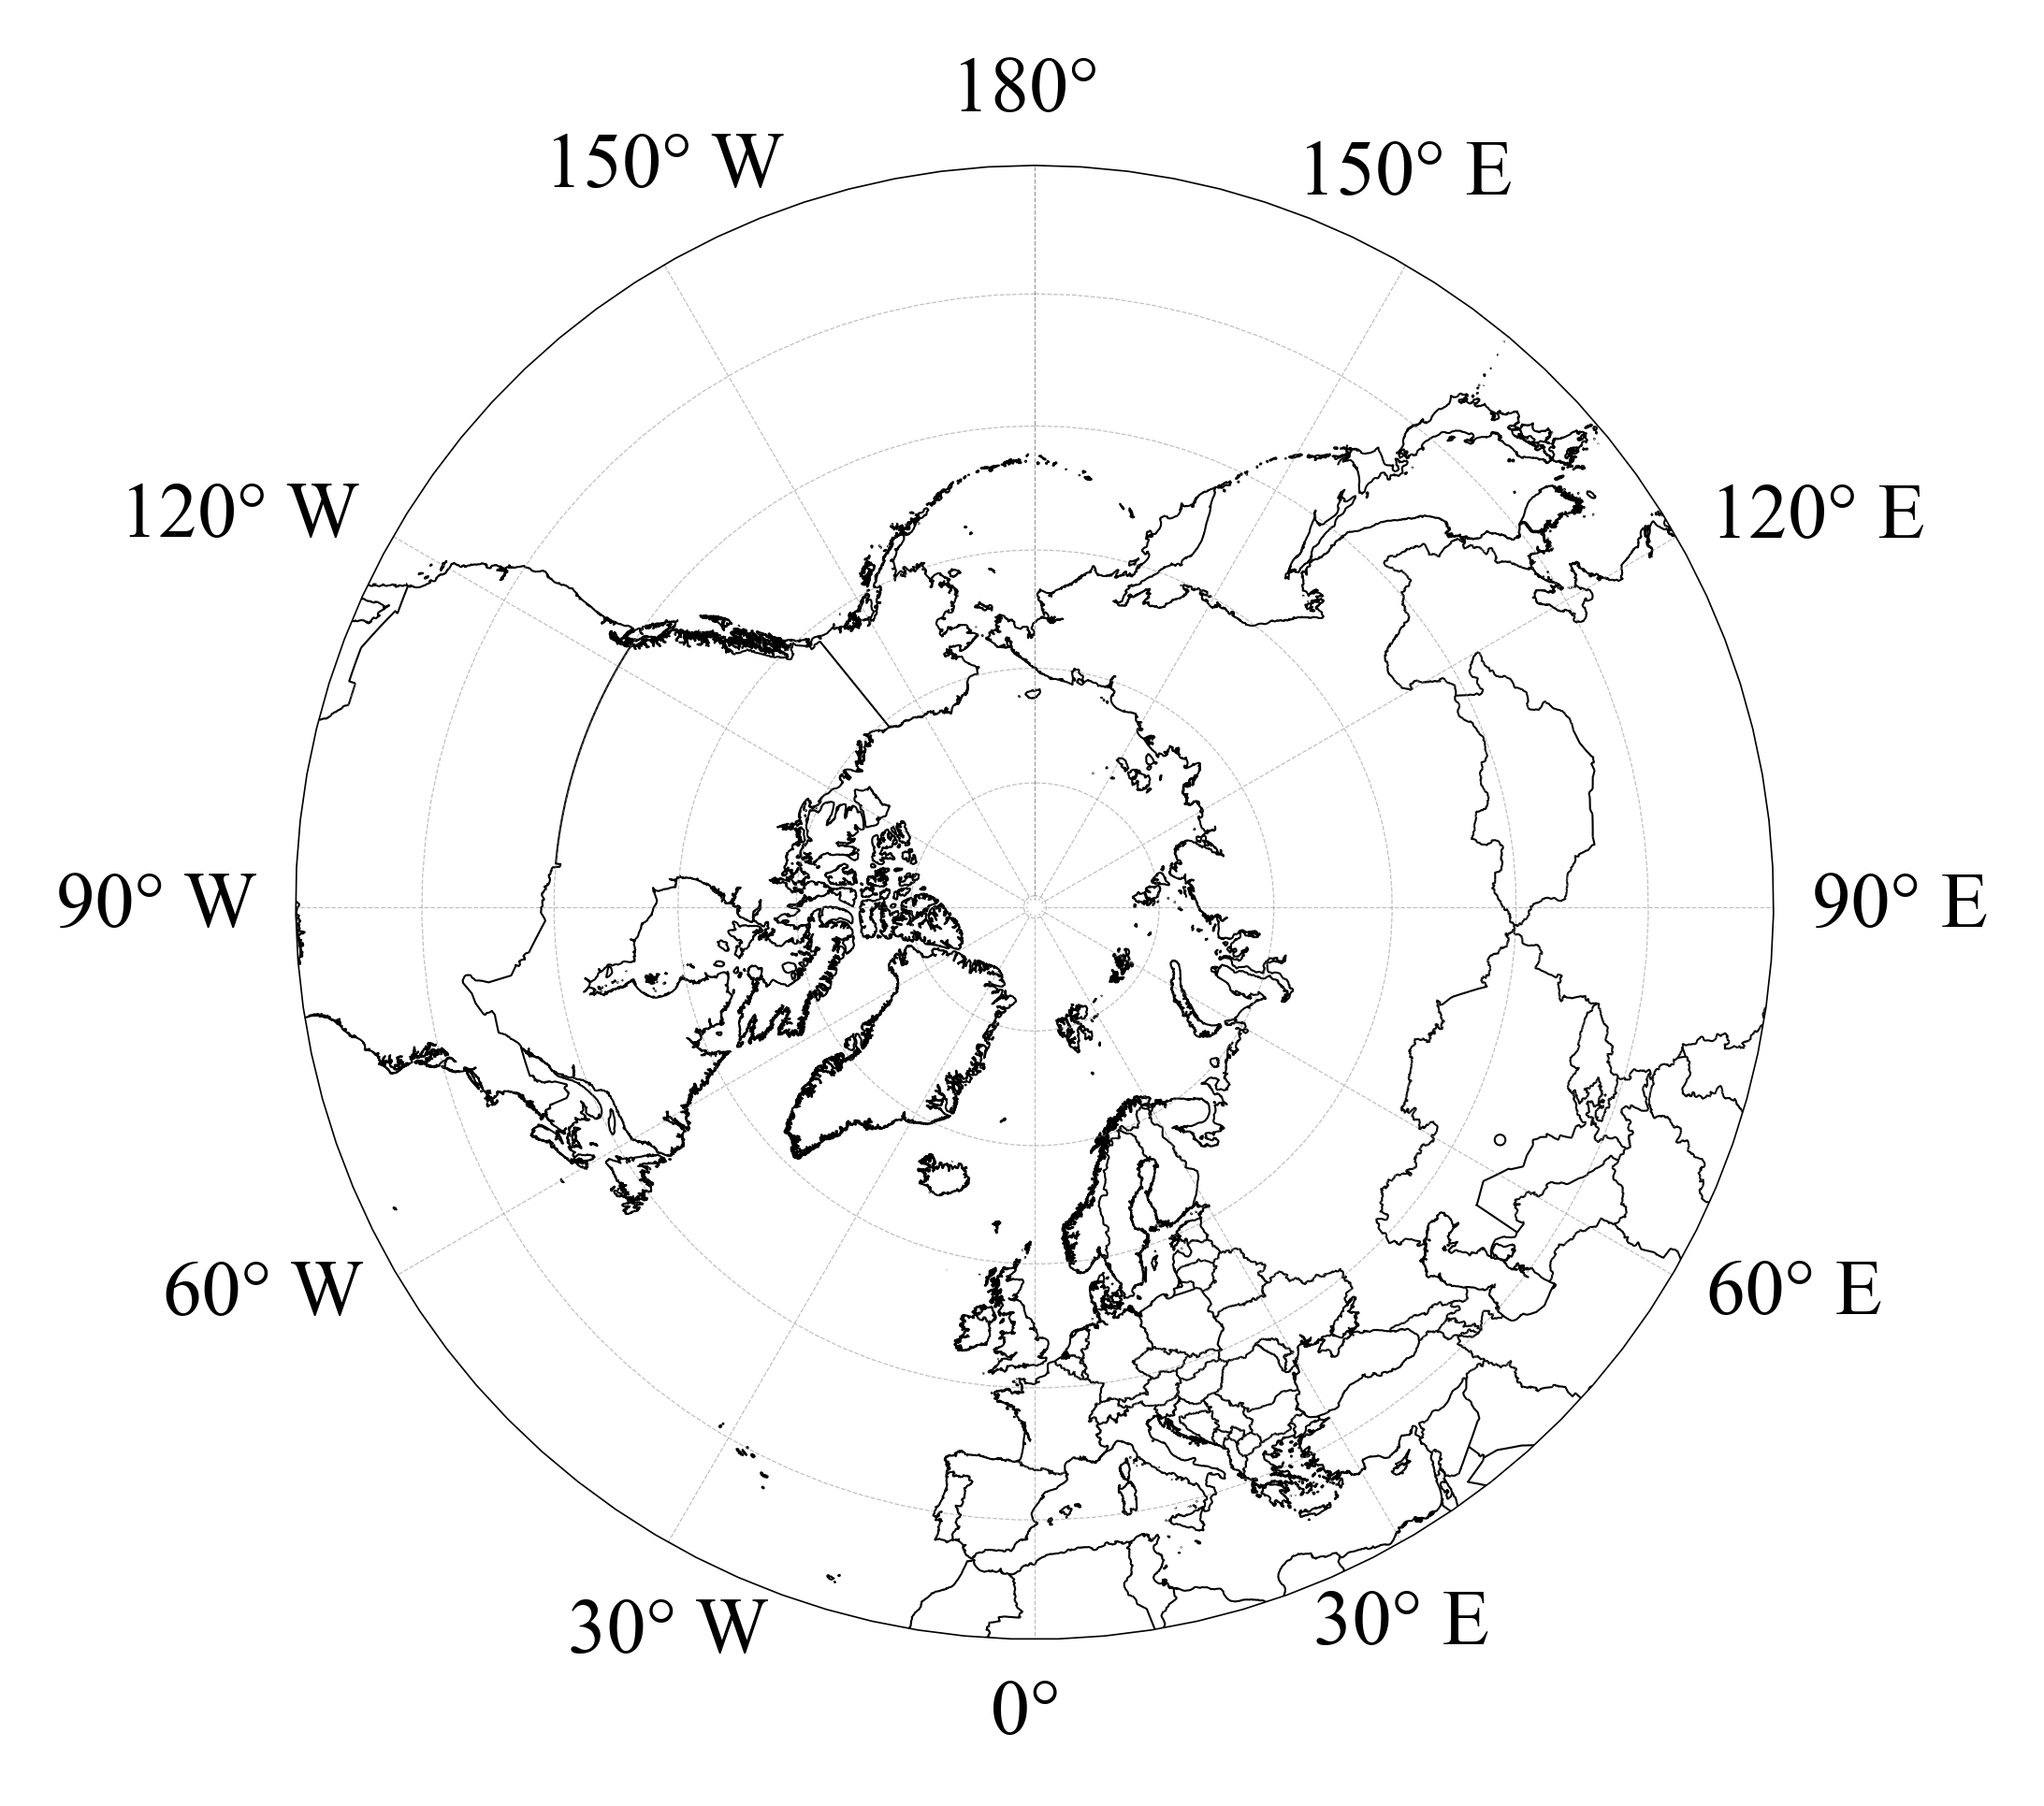

In [8]:
fig, ax = hemisphere_plot(southextent=30,)

#### A function to plot the global map

In [9]:
def globe_plot(
    figsize=None,
    fm_left=0.12, fm_right=0.94, fm_bottom=0.1, fm_top=0.99,
    ax_org = None,
    ):
    '''
    ----Input
    figsize: if by default None, it is set as: np.array([13.2, 6.6]) / 2.54
    fm_*: the space around four side of the graph
    ax: if specified, it will not create a new fig and ax.
    
    ----output
    
    '''
    import numpy as np
    import cartopy as ctp
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from cartopy.mpl.ticker import LongitudeFormatter
    from cartopy.mpl.ticker import LatitudeFormatter
    
    mpl.rcParams['figure.dpi'] = 600
    mpl.rc('font', family='Times New Roman', size=10)
    
    if (figsize is None):
        figsize = np.array([13.2, 6.6]) / 2.54
    
    if (ax_org is None):
        fig, ax = plt.subplots(
            nrows=1, ncols=1,
            figsize = figsize, # figure size in inches
            subplot_kw={'projection': ctp.crs.PlateCarree()},
            )
    else:
        ax = ax_org
    
    ax.set_extent(
        [-180, 180, -90, 90],
        crs = ctp.crs.PlateCarree(),
        )
    
    coastline = ctp.feature.NaturalEarthFeature(
        'physical', 'coastline', '10m', edgecolor='black',
        facecolor='none', lw = 0.1)
    ax.add_feature(coastline)
    borders = ctp.feature.NaturalEarthFeature(
        'cultural', 'admin_0_boundary_lines_land', '10m', edgecolor='black',
        facecolor='none', lw = 0.1)
    ax.add_feature(borders)
    
    gl = ax.gridlines(
        crs = ctp.crs.PlateCarree(), linewidth = 0.1,
        color = 'gray', alpha = 0.5, linestyle='--',
        xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
        draw_labels=["bottom", "left"],
        xformatter=LongitudeFormatter(degree_symbol='° '),
        yformatter=LatitudeFormatter(degree_symbol='° '),
        )
    
    if (ax_org is None):
        fig.subplots_adjust(
            left=fm_left, right = fm_right, bottom = fm_bottom, top = fm_top)
        return fig, ax
    else:
        return ax


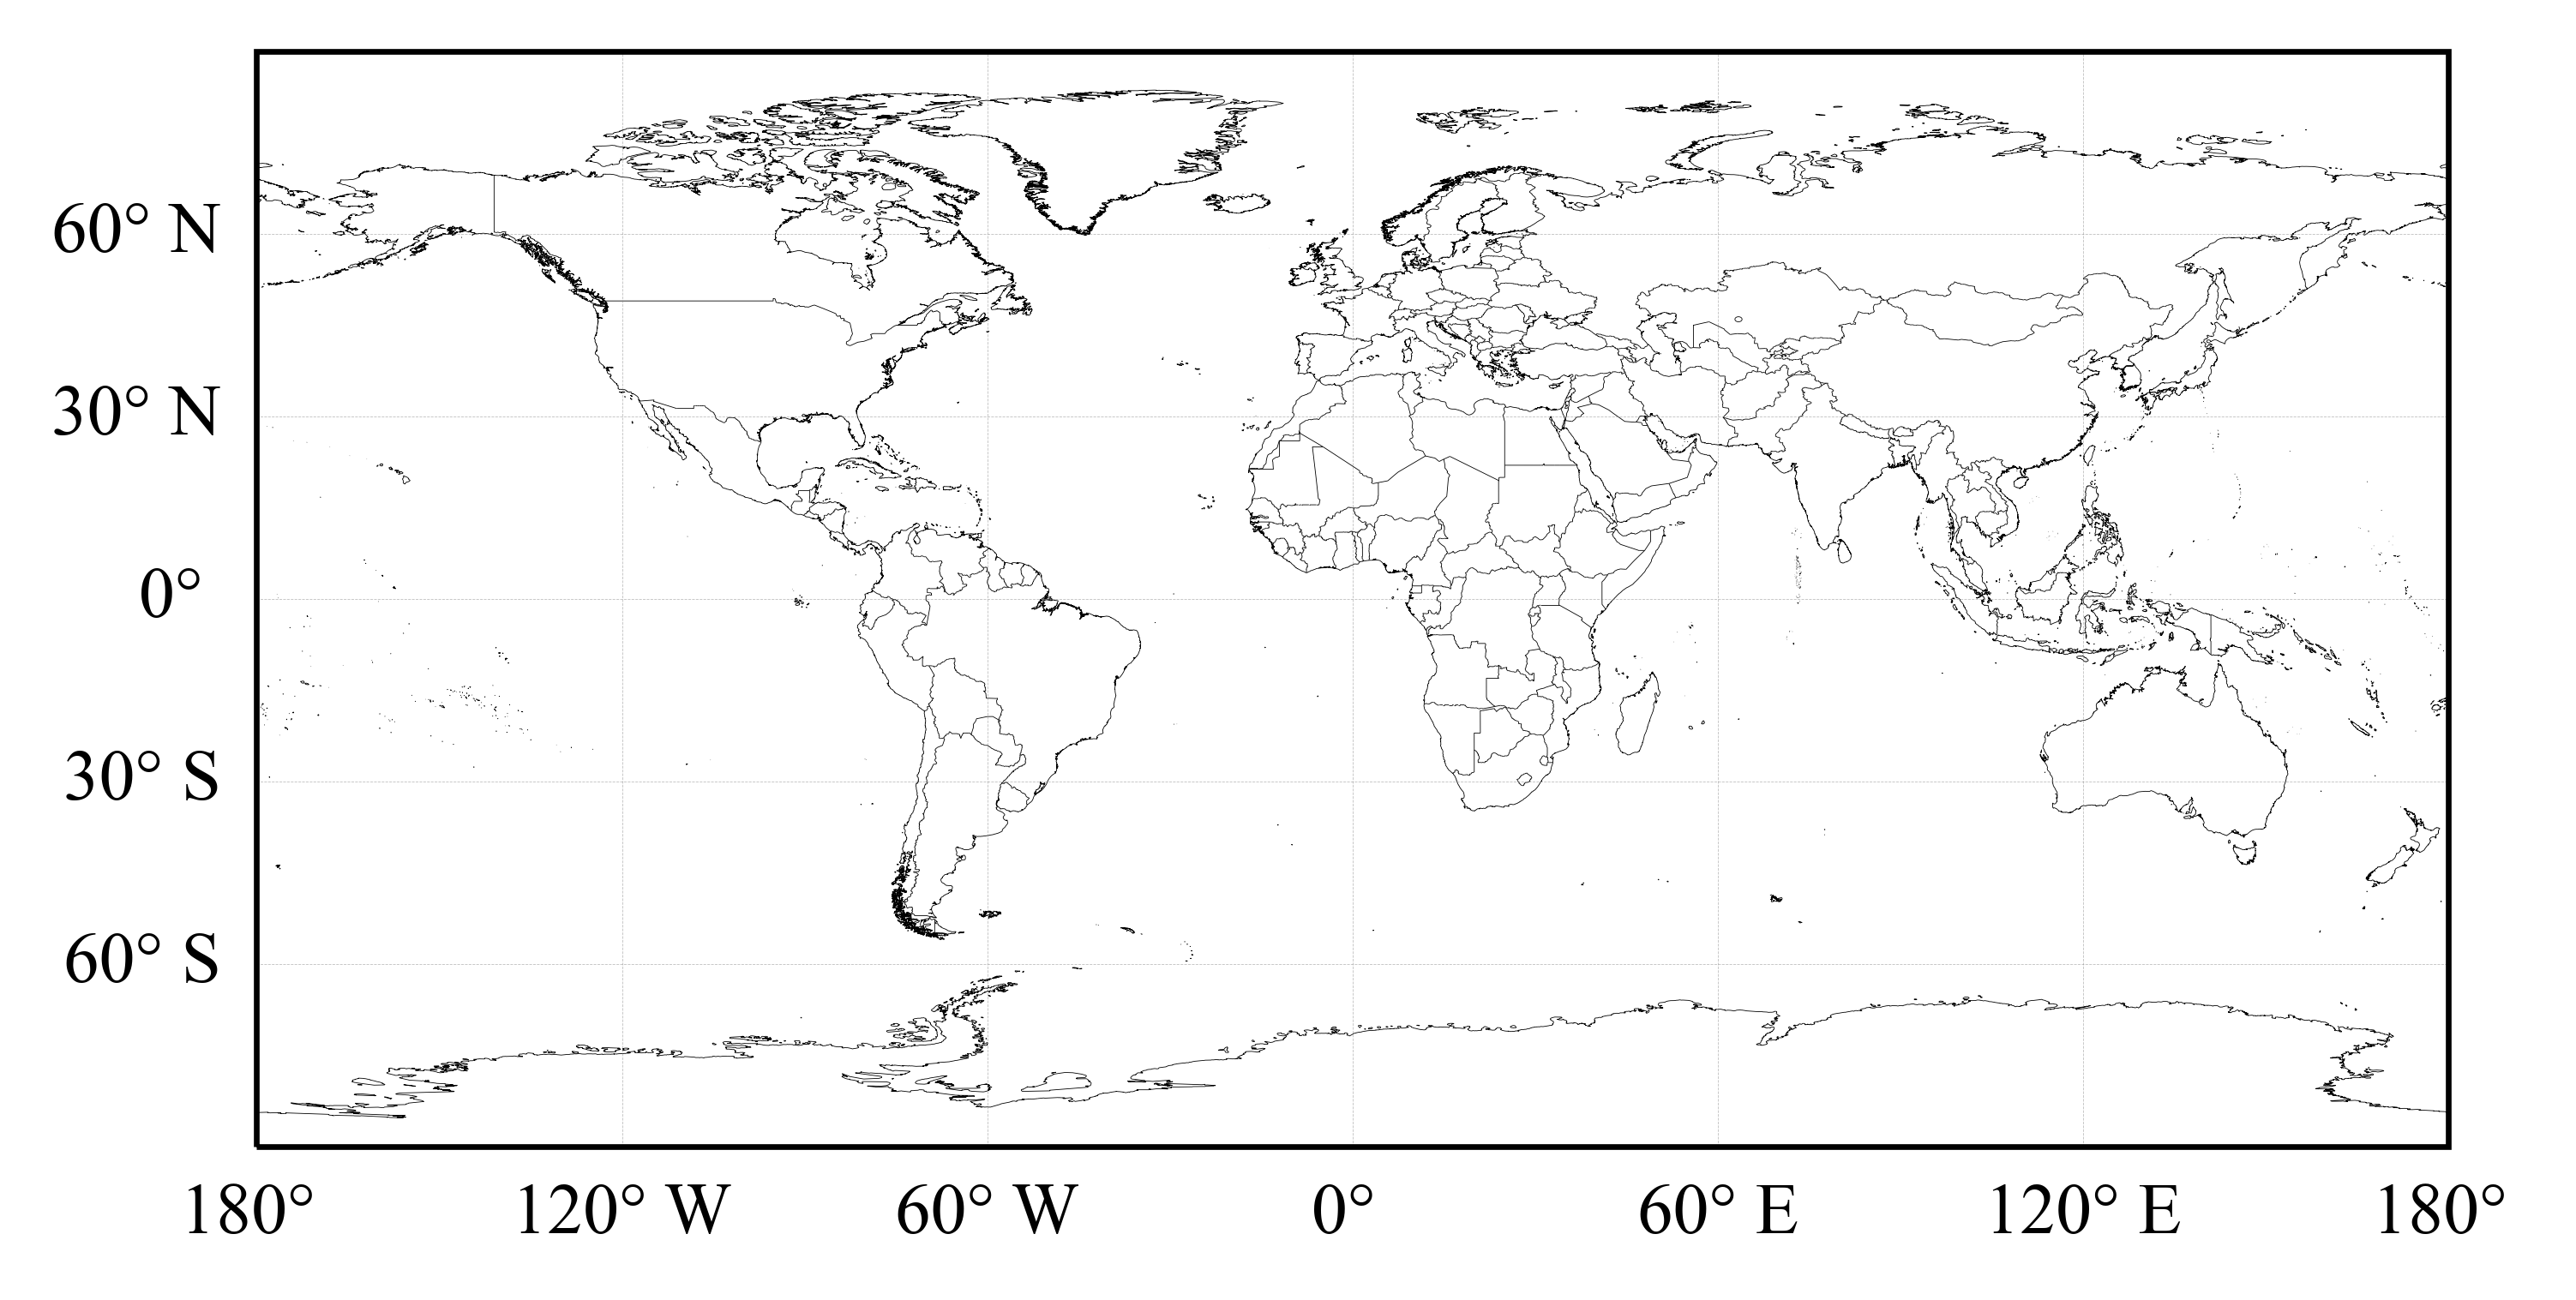

In [10]:
fig, ax = globe_plot()